# Trabajo final para la asignatura APDB.

## Máster en Data Science y Big Data.

##### Autor: Miguel Ángel Berrocal De Ó
##### Fecha: Septiembre 2017

# Introducción:

## 1. Problema:
El problema elegido para el trabajo es uno de los datasets de aprendizaje de kaggle, en el que el objetivo es predecir el precio de venta de viviendas a partir de sus características. Para más información sobre el problema y descarga de datasets ir a la página de la competici ́on en kaggle.

## 2. Objetivo:

### Poner en prácticas las técnicas de preprocesado vistas en clase:

El objetivo de este trabajo es practicar con las diferentes herramientas que Spark nos proporciona para el procesamiento distribuido de grandes cantidades de datos. Hay que tener en cuenta las siguientes consideraciones:

* Cualquier procesamiento sobre el dataset debe realizarse mediante las herramientas que Spark nos proporciona. Es decir, no podemos cargar en python local (Pandas, Numpy, etc.) el dataset, procesarlo y luego volver a subirlo a Spark.
    
* De la misma forma que se ha visto en clase, es posible (y se valorará positivamente) traernos de spark pequeños fragmentos de datos (normalmente estadísticas y agregaciones) para por ejemplo, procesarlos de forma más cómoda mediante Pandas o visualizarlos mediante matplotlib.
    
### Aplicar modelos de Machine Learning:

El principal objetivo del trabajo es la resolución de problemas mediante Spark, por lo que la obtención de predicciones óptimas es un objetivo secundario (aunque se valorará positivamente).

## 3. Evaluación:

* El entregable será un fichero comprimido que contenga el notebook con la solución y la estructura de carpetas/ficheros adicionales que se haya usado. El notebook con la solución debe estar comentado (brevemente).

* La solución debe contener como m ́ınimo una fase de preprocesado y otra de análisis con al menos dos modelos diferentes (con su correspondiente ajuste de parámetros) similar a lo visto en clase. Se valorará positivamente el uso de funciones y objetos que no se han visto explícitamente en clase (aunque no es necesario).

* También se valorará la subida de soluciones a kaggle, en este caso se adjuntarña en el correo de la entrega el usuario de kaggle con el que se ha realizado dicha subida.






# Inicio de la práctica:

El trabajo de evaluación de la asignatura consiste en practicar las técnicas vistas en clase sobre un dataset de aprendizaje de Kaggle. El conjunto de datos elegido ha sido https://www.kaggle.com/c/house-prices-advanced-regression-techniques y se encuentra disponible para su consulta y descaga online. En concreto, se trata un problema de regresión en el que se pretende estimar el precio de venta de viviendas a partir de una serie de características.

Siguiendo un esquema similar al propuesto por el profesor, la entrega va a constar de tres ficheros en formato **Jupyter Notebook**, entre los que se distribuirán las tareas de análisis exploratorio de los datos, preprocesado y aplicación de modelos.

En este primer notebook, nos centraremos en el análisis exploratorio de los datos. Este paso es muy importante, ya que nos permite hacernos una idea de la distribución que siguen nuestros datos, sus valores perdidos (ya contengan información o no), la correlación entre las variables y la salida, etc.


# 1. Análisis descriptivo de los datos.

## Inicialización de Spark y carga de librerías

In [3]:
import sys
import os

spark_path = "/Applications/spark-2.1.0-bin-hadoop2.7"
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Entrega") \
    .getOrCreate()

spark

In [273]:
from pyspark.sql.functions import col, count, mean, sum as agg_sum
from pyspark.sql.functions import lit 
from pyspark.sql.types import IntegerType, DoubleType 
from pyspark.sql.functions import  udf 
from pyspark.mllib.stat import Statistics 
from pyspark.mllib.linalg import Vectors

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

%matplotlib inline

## Carga de los datos

In [9]:
train_path = "datos/train.csv"
test_path = "datos/test.csv"

# Por simplicidad, se ha elegido la opción de inferir esquema de los datos
test = spark.read.csv(test_path, header=True, inferSchema=True, nullValue= 'NA')
train = spark.read.csv(train_path, header=True, inferSchema=True,nullValue= 'NA')

# Se crea la columna Sale price para los datos test
test = test.withColumn('SalePrice', lit(None).cast('Integer'))

In [116]:
# Se comprueba que ambos esquemas han sido inferidos correctamente
if train.schema == test.schema:
    print("Las columnas tienen el mismo esquema!!")
else:
    print("Error, el esquema de los datasets no se ha inferido correctamente")

Las columnas tienen el mismo esquema!!


In [130]:
# Una buena práctica es guardar en una variable las columnas del dataset
col = train.columns
train.select(col[:10]).show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|
+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+
|  1|        60|      RL|         65|   8450|  Pave| null|     Reg|        Lvl|   AllPub|
|  2|        20|      RL|         80|   9600|  Pave| null|     Reg|        Lvl|   AllPub|
|  3|        60|      RL|         68|  11250|  Pave| null|     IR1|        Lvl|   AllPub|
|  4|        70|      RL|         60|   9550|  Pave| null|     IR1|        Lvl|   AllPub|
|  5|        60|      RL|         84|  14260|  Pave| null|     IR1|        Lvl|   AllPub|
+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+
only showing top 5 rows



In [12]:
# Se tienen un total de 81 columnas
print("Número de columnas: {}".format(len(col)))

Número de columnas: 81


## Análisis de los datos: 

En este apartado se procede a la realización de un análisis del conjunto de datos. Para ello, se unirán los conjuntos de entrenamiento y test en un único dataframe, a partir del cuál se extraerán estadísticas que ayuden a determinar la distribución de las varaibles del conjunto de datos con el objetivo de imputar los valores perdidos.

En cuanto a los valores faltantes, hay que discriminar entre los que realmente son perdidos y aquellos en los que NA es un valor permitido en el conjunto de datos

In [118]:
# Hay que verificar que las columnas siguen el mismo orden y esquema
if train.columns==test.columns:
    # Unión de los datasets
    union = train.union(test)
    print("Las columnas de ambos conjuntos tienen el mismo orden!!")
else:
    print("Error")

Las columnas de ambos conjuntos tienen el mismo orden!!


### Unificación de los conjuntos de datos

In [134]:
# Verificación de la unión 
union.select(col[:10]).show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|
+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+
|  1|        60|      RL|         65|   8450|  Pave| null|     Reg|        Lvl|   AllPub|
|  2|        20|      RL|         80|   9600|  Pave| null|     Reg|        Lvl|   AllPub|
|  3|        60|      RL|         68|  11250|  Pave| null|     IR1|        Lvl|   AllPub|
|  4|        70|      RL|         60|   9550|  Pave| null|     IR1|        Lvl|   AllPub|
|  5|        60|      RL|         84|  14260|  Pave| null|     IR1|        Lvl|   AllPub|
+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+
only showing top 5 rows



In [121]:
# Representación del esquema
union.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

### Detección de los valores perdidos

In [122]:
# Funciones que permiten el cálculo de los valores perdidos por variable
from pyspark.sql.functions import col, count, sum as agg_sum

# Devuelve el agregado de valoes perdidos para cada columna pasada por parámetro
def count_nulls(c):
    return agg_sum(col(c).isNull().cast(IntegerType())).alias(c)

# Devuelve la agregación de todas las columnas
def tmp1(df):
    # Definimos la operación para cada columna del DF.
    exprs = [count_nulls(c) for c in df.columns]
    return df.agg(*exprs).collect()

# El resultado se convierte a diccionario para facilitar el tratamiento
dic_list = tmp1(union)[0].asDict()

# Se filtran aquellas variables sin valores perdidos
dic_filtered = dict((k, v) for (k, v) in dic_list.items() if v > 0)

# Se oredenan en función del número de valores perdidos
temp = sorted(dic_filtered.items(), key=lambda x: x[1], reverse = True)

In [127]:
# Se crean listas que almacenan los valores y etiquetas
var = [var[0] for var in temp]
value = [value[1] for value in temp]

print("Se tienen un total de {} variables con valores perdidos".format(len(value)))

Se tienen un total de 35 variables con valores perdidos


### Representación del número de valores perdidos por variable

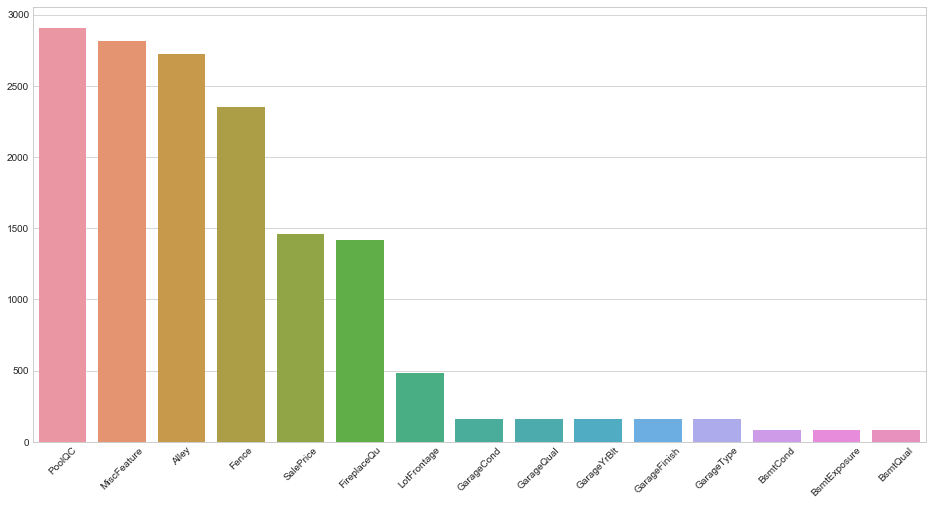

In [125]:
# Por motivos de representación sólo se mostrarán las 15 variables con mayor número de valores perdidos
sns.set_style()
plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
ax = sns.barplot(x=var[:15], y=value[:15])

### Clasificación de las variables por tipo de dato 

In [150]:
# A continuación se van a separar aquellas columnas de tipo categórico
categ = [tupla[0] for tupla in union.dtypes if tupla[1] == "string"]
no_categ = [tupla[0] for tupla in union.dtypes if tupla[1] != "string"]

print("Se tienen {} columnas de tipo categórico y {} de tipo no categórico.".format(len(categ), len(no_categ)))

Se tienen 43 columnas de tipo categórico y 38 de tipo no categórico.


### Estadísticas de las variables no categóricas

In [149]:
# Ahora se representarán estadísticas de las variables no categóricas.
from math import ceil
num_vars = 5
cuts = len(no_categ)/num_vars
for jj in range(ceil(cuts)):
    union.select(no_categ[jj*3:jj*3+num_vars]).describe().show()

+-------+-----------------+------------------+------------------+-----------------+-----------------+
|summary|               Id|        MSSubClass|       LotFrontage|          LotArea|      OverallQual|
+-------+-----------------+------------------+------------------+-----------------+-----------------+
|  count|             2919|              2919|              2433|             2919|             2919|
|   mean|           1460.0|  57.1377183967112| 69.30579531442663|10168.11408016444|6.089071599862967|
| stddev|842.7870430897713|42.517627829150314|23.344904706927394|7886.996359105535|1.409947206614697|
|    min|                1|                20|                21|             1300|                1|
|    max|             2919|               190|               313|           215245|               10|
+-------+-----------------+------------------+------------------+-----------------+-----------------+

+-------+-----------------+-----------------+------------------+-----------------

## Extracción de una muestra de datos para su análisis local.

En este apartado se extraerá una muestra aleatoria de nuestro conjunto de datos para analizarla con herramientas estadísitcas de visualización que no está aún disponibles en Spark, como heatmaps y pairplots.

In [238]:
# Con esta instrucción se extrae una muestra del 50% del total de los datos sin reemplazamiento y fijando un valor
# semilla. Para conjunto de datos más grandes hay que tener cuidado de la fracción que se trae a local para no saturar
# la memoria.
muestra = train.sample(False, 0.5, 2017)

# Conversión de Spark Dataframe a Pandas Dataframe
muestra = muestra.toPandas()

In [253]:
muestra.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
2,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
3,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000
4,12,60,RL,85.0,11924,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,New,Partial,345000


### Mapa de calor

La forma más sencilla de explorar las relaciones entre las variables es a través de la representación gráfica de una matriz de correlación. Lo más habitual es mediante un mapa de calor (heatmap), donde las variables más correladas aparecen representadas en tonos más intensos.

* Rojo: Cuanto más intenso mayor correlación directa.
* Azul: Cuanto más intenso mayor correlación inversa.

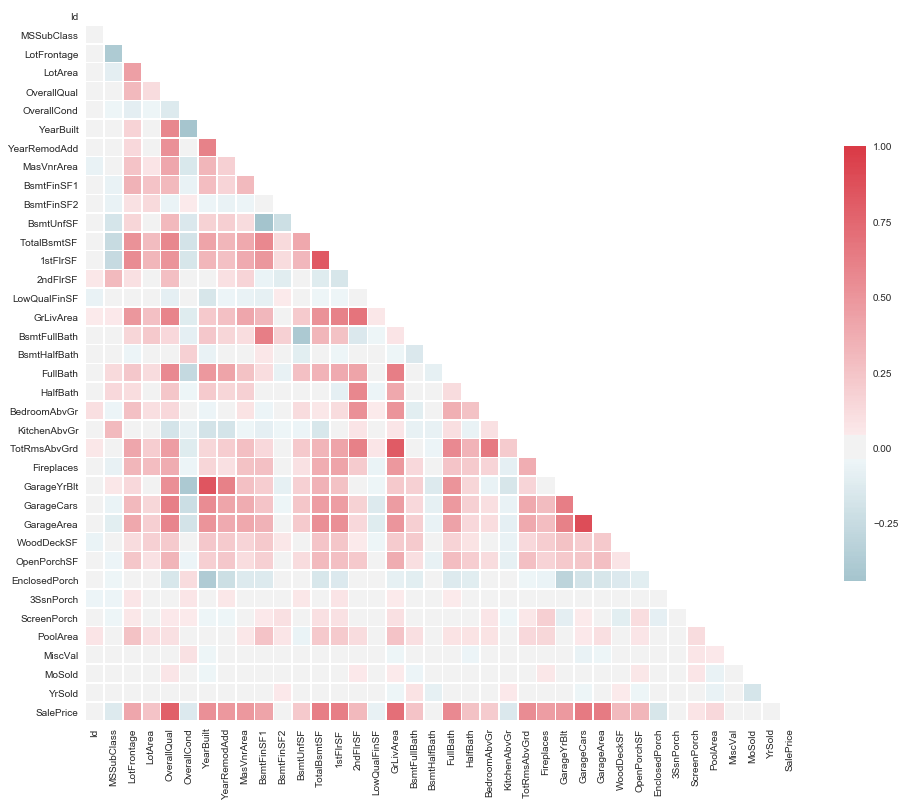

In [254]:
# Establecemos la plantilla
sns.set(style="white")

# Calculamos la matriz de correlación
corrmat = muestra.corr()

# Máscara que elimina la parte simétrica de la matriz de correlación
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Dimensiones del gráfico
f, ax = plt.subplots(figsize=(16, 16))

# Paleta de colores personalizada
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Dibujo del mapa de calor
sns.heatmap(corrmat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Tras una inspección rápida podemos sacar las siguientes conclusiones:

* Variables más correladas con la salida: **OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmntSF, 1stFlrSF**, ...
* Variables más correladas a pares: **GarageCars y GarageArea**, **GarageYrBlt y YearBuilt**, **1stFlrSF y TotalBsmtSF** , ...

Las variables más correladas pueden indicar la existencia multicolinealidad, por lo que resulta esencial prestar especial atención en ellas. Las variables asociadas al garage parecen ser candidatas a estar muy correladas, así como la que indica la superficie de la primera planta y el sótano.


Los mapas de calor son herramientas que nos permiten detectar fácilmente este tipo de situaciones, especialmente en problemas en los que resulta necesario seleccionar características, como es el caso que nos ocupa.

### Mapa de calor aumentado:

A continuación, se vuelve a representar el mapa de calor sobre las 10 variables más correladas con la salida. Esto nos permite hacer un estudio mas exhaustivo de las dependencias entre ellas. En esta ocasión, además de indicar el grado de correlación a través del color (se ha utilizado una escala diferente, centrado en 0.55 en lugar de 0 como el caso anterior) se hace también numéricamente.

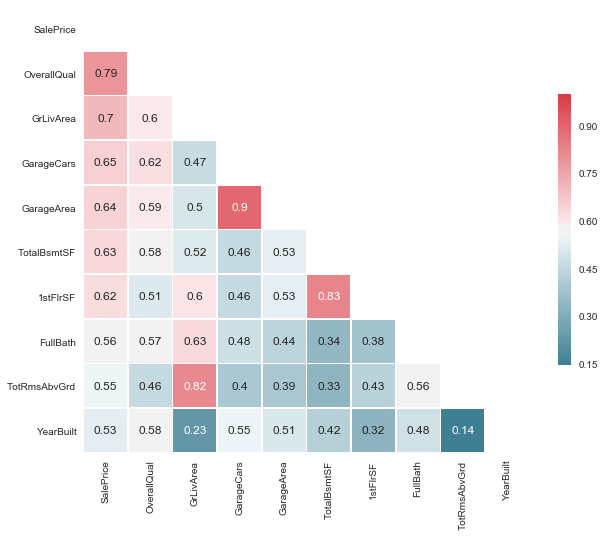

In [265]:
# Establecemos la plantilla
sns.set(style="white")

# Calculamos la matriz de correlación
corrmat = muestra.corr()

# Se determinan las 10 variables mas correladas con la salida
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(muestra[cols].dropna().values.T)

# Máscara que elimina la parte simétrica de la matriz de correlación
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Dimensiones del gráfico
f, ax = plt.subplots(figsize=(10, 10))

# Paleta de colores personalizada
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Dibujo del mapa de calor. Esta vez centrado en 0.55 para facilitar la distinción de colores
sns.heatmap(cm, mask = mask, annot=True, vmax=1,cmap=cmap, yticklabels=cols.values, xticklabels=cols.values,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Tras poner el foco en las 10 variables más correladas con la salida se van a comentar brevemente los resultados obtenidos:

* Las variables marcadas con tonos rojos en la primera columna tienen una correlación mayor del 60% con la salida. Estás son: **OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF y 1stFlrSF**
* Las variables **GarageArea y GarageCars**: El número de coches que caben en el garage es consecuencia del área de este, por lo que ambas variables vienen a decir prácticamente lo mismo. Se podría eliminar cualquiera de las dos, pero en este caso se decide eliminar aquella con menor correlación con la salida, GarageArea.
* Las variables **1stFlrSF y TotalBsmntSF**: Parece razonable que la superficie del sótano esté relacionada con la superficie de la primera planta. 
* Las variables **TotRmsAbvGrd y GrLivArea**: El número total de habitaciones (sin contar cuartos de baño) guarda relación con la superficie total habitable de la vivienda.


## Pairplot:

A continuación, se representa el diagrama pairplot. Permite visualizar a través de un conjunto de scatter plots las relaciones entre variables. En la diagonal, se muestra el histograma de la variable correspondiente. Para su estudio, y tal y como se ha justificado en el apartado anteiror, se han eliminado las variables **1stFlrSF y GarageArea**, al presentar un alto grado de correlación entre ellas.

Gracias a esta herramienta se puede extraer de forma rápida y cómoda muchísima información.

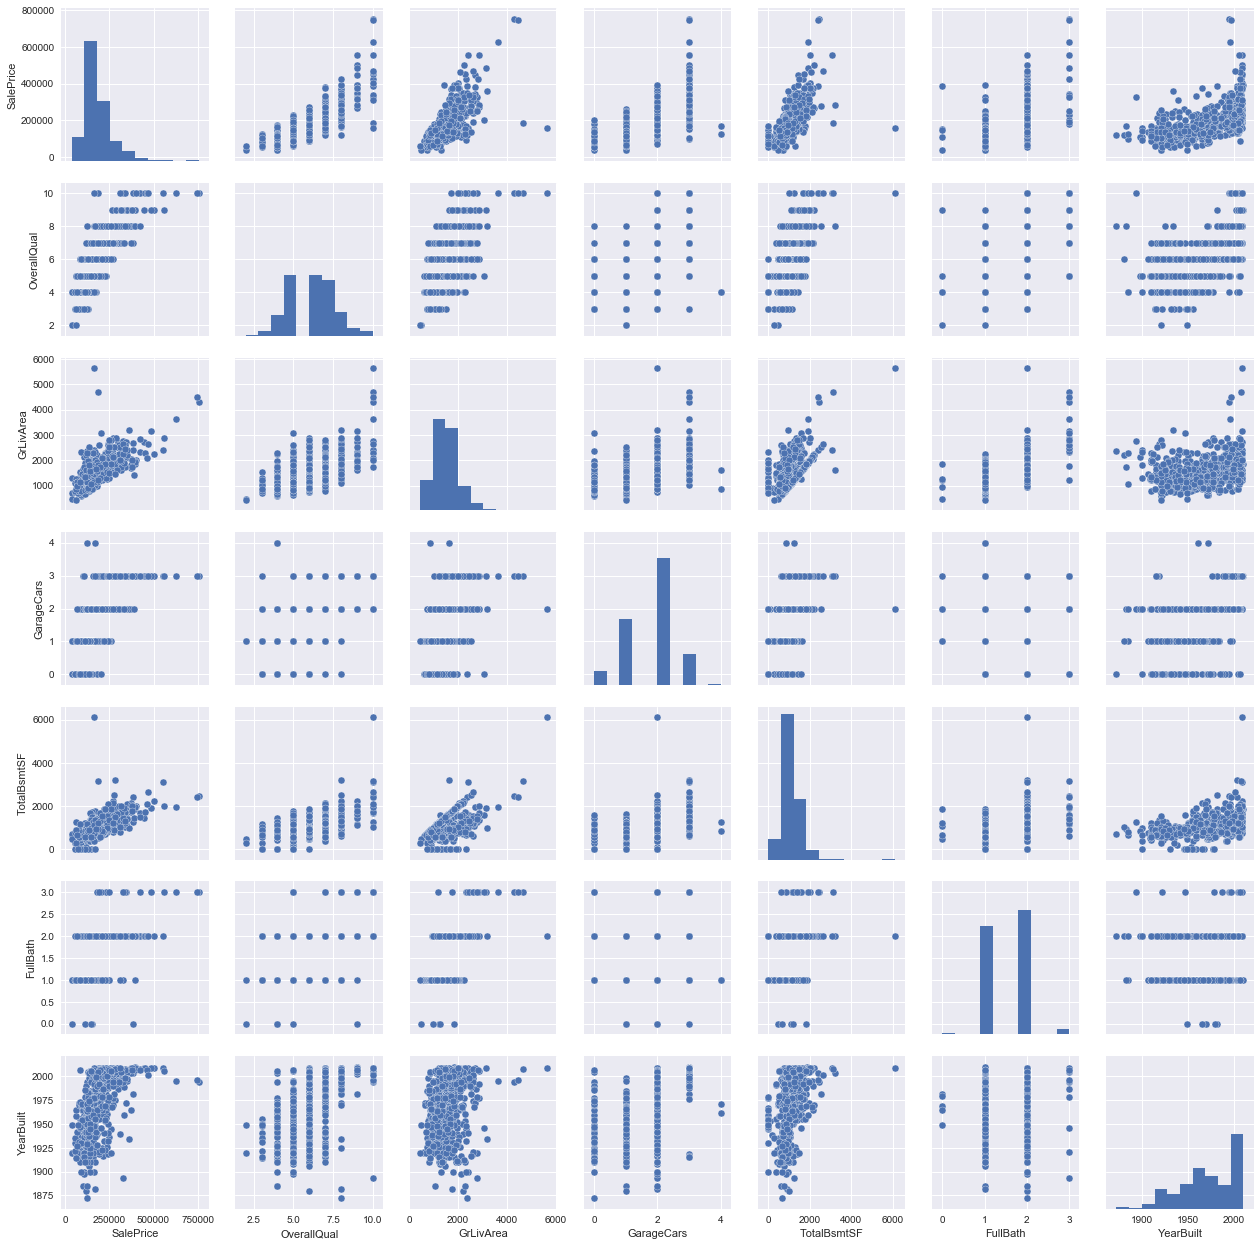

In [267]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(muestra[cols].dropna(), size = 2.5);

El diagrama anterior nos permite sacar conlusiones interesantes.

Si nos fijamos en el diagrama de puntos entre **TotalBsmtSF y GrLiveArea** se puede apreciar una serie de puntos que delimitan una especie de frontera. Esto se traduce a que normalmente no se tiene un sótano con mayor superficie que la planta baja de la casa.

Se observa que tanto la superficie del sótano como la de la planta baja también son variables determinantes y guardan una relacion aproximadamente lineal con el precio de la casa, aunque no tienen una varianza constante y presentan heterocedasticidad.

Por su parte, la valoración general de la vivienda (**OverallQual**) parece seguir una tendencia lineal con el precio de la viivenda. Esta relación la estudiaremos en el siguiente apartado.

## Boxplot sobre OverallQuall y Yearbuilt:

En este apartado vamos a estudiar la dependencia del precio de la vivienda con estas dos variables categóricas.

### OverallQual

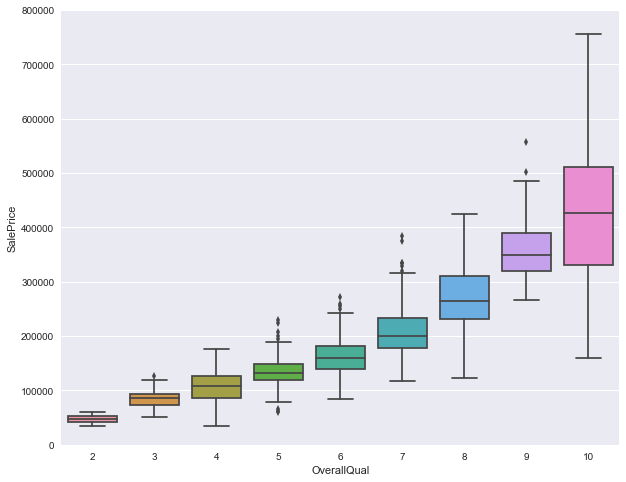

In [287]:
# Se crea un dataframe con las variables a representar
data = pd.concat([muestra['SalePrice'], muestra['OverallQual']], axis=1)

# Se determina las dimensiones del gráfico
f, ax = plt.subplots(figsize=(10, 8))

# Se representa el gráfico
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)

# Se fijan los márgenes de los ejes
fig.axis(ymin=0, ymax=800000);

Como se ha comentado en el pairplot, la dependencia de la valoración de la vivienda con su precio de venta sigue una tendencia mas o menos lineal pero con una varianza creciente. El criterio de calificación de la vivienda puede ser bastante subjetivo, de ahí que existan tales variaciones, sobre todo a partir de una valoración igual a 5.

### YearBuilt

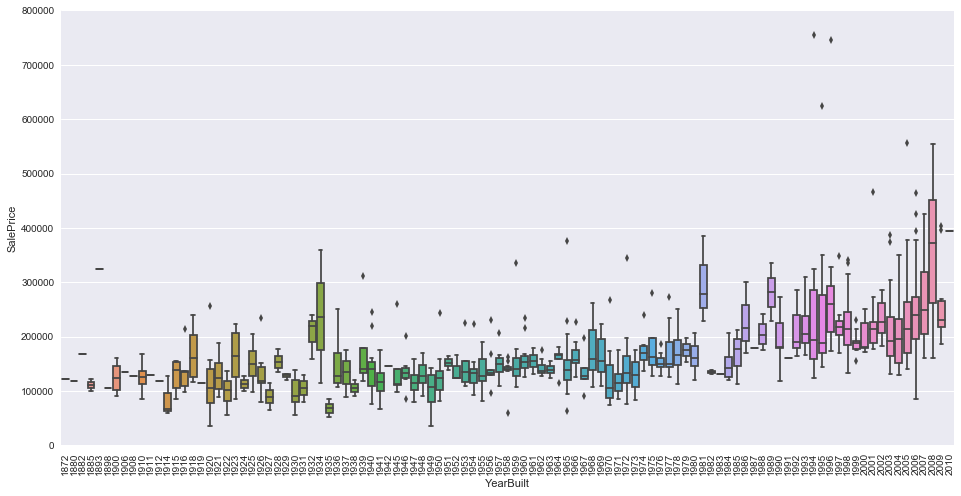

In [263]:
# Se crea un dataframe con las variables a representar
data = pd.concat([muestra['SalePrice'], muestra['YearBuilt']], axis=1)

# Se determina las dimensiones del gráfico
f, ax = plt.subplots(figsize=(16, 8))

# Se representa el gráfico
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=data)

# Se fijan los márgenes de los ejes
fig.axis(ymin=0, ymax=800000);

# Se rotan las etiquetas para una correcta lectura
plt.xticks(rotation=90);

En este caso no se aprecia una tendencia tan marcada como en el apartado anterior, sin embargo, parece que las casas más modernas suelen tener un precio más elevado que las antiguas.

## Transformaciones de variables

Nuestro objetivo principal es caracterizar lo mejor posible la variable objetivo "SalePrice". Para ello, se han de comprobar las hipótesis estadísitcas sobre las que se basa el análisis multivariante.Este paso resulta de suma importancia cuando se quieren aplicar técnicas de análisis multivariantes, ya que presuponen un comportamiento determinado de los datos, y que en caso de no tenerlo se ha de hacer ciertas sobre los datos. De lo contrario, estaríamos dando por ciertas hipótesis sobre nuestros datos que en realidad no se está cumpliendo y, por tanto, se llegarían a conclusiones erróneas. 

Las cuatro consideraciones más importantes que han de ser testadas son las siguientes:

* **Normalidad:** La distribución de los datos debería seguir una normal. Conseguir esto es importante porque muchos estadísticos se basan en la normalidad de los datos. Hay que insistir que en este ejercicio se está comprobando la hipótesis de normalidad univariante, aunque lo que se debería comprobar es la normalidad multivariante (una no implica la otra). Solucionando el problema de normalidad, también se suele solucionar otros como la heterocedasticidad.

* **Homocedasticidad:** Implica que la varianza de la variable dependiente es constante a lo largo del rango de las variables predictoras. Esta consideración asegura que el error cometido a la hora de predecir no depende del valor que tomen los predictores.

* **Linealidad:** Una forma cómoda de detectarla es mediante la inspección de scatter plots. Si siguen un patrón no lineal habría que valorar transformar dicha variable.

* **Errores incorrelados:** Los errores correlados suelen aparecer en series temporales cuando ciertos patrones se encuentran realacionados temporalmente.



### SalePrice:


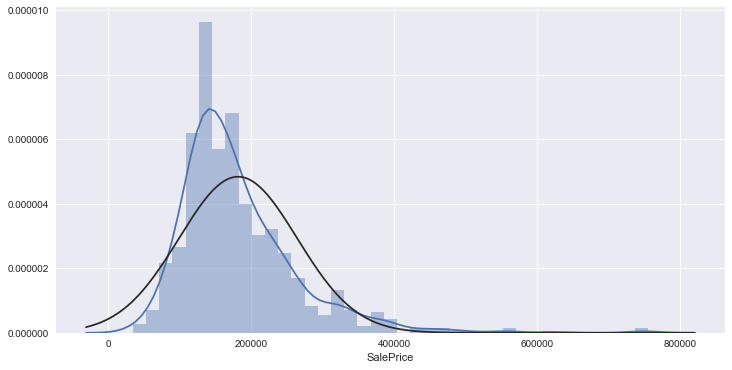

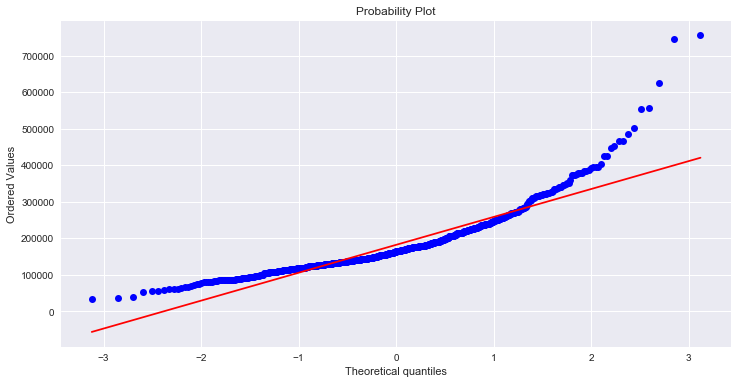

In [283]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(muestra['SalePrice'], fit=norm);
fig = plt.figure(figsize=(12, 6))
res = stats.probplot(muestra['SalePrice'], plot=plt)

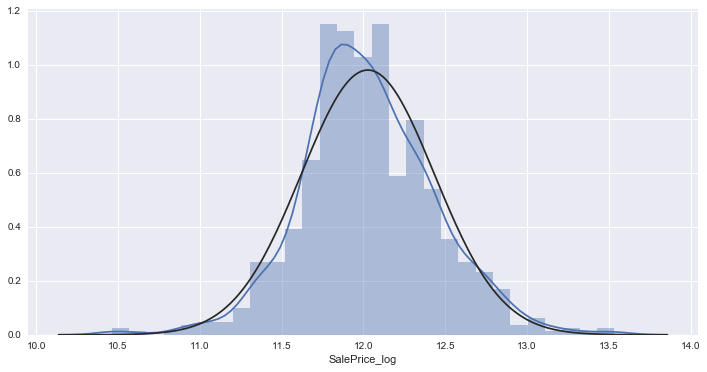

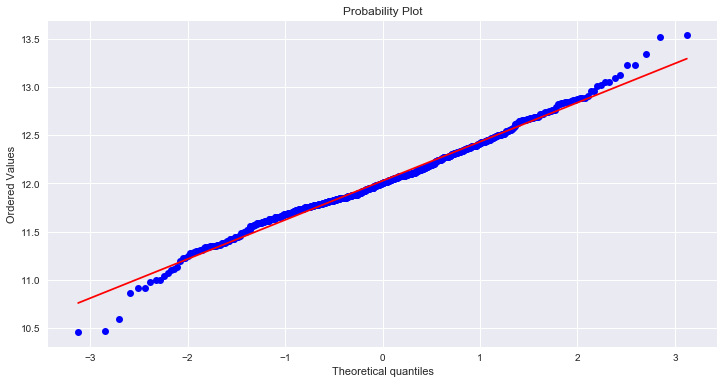

In [286]:
f, ax = plt.subplots(figsize=(12, 6))
muestra['SalePrice_log'] = np.log(muestra['SalePrice'])
sns.distplot(muestra['SalePrice_log'], fit=norm);
fig = plt.figure(figsize=(12, 6))
res = stats.probplot(muestra['SalePrice_log'], plot=plt)

Se comprueba que la transformación logarítmica sobre la variable dependiente ha tenido un efecto positivo en nuestro camino hacia la búsqueda de la normalidad. En el siguiente notebook se aplica esta metodología a aquellas variables que sobre el paiplot parecen no seguir una distribución normal.

In [264]:
spark.stop()

Aquí finaliza la primera parte del trabajo. El siguiente notebook se centrará en la imputación de valores perdidos, escalado de variables y preparación de los datos para, posteriormente, aplicar modelos de machine learning que permitan predecir el precio de la vivienda.